# LDA Extension


In [1]:
# Add root to the sys.path

import sys
from pathlib import Path

ROOT = Path().resolve().parents[0]
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

In [2]:
%load_ext autoreload
%autoreload 2

import copy

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from kornia.augmentation import RandomGaussianNoise
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torchvision import datasets

from image import MNIST, Model, plot_eigenspectrum

device = "cpu"
n_layer = 3

/Users/shidqietaufiqurrahman/workspace/miniconda3/envs/fact-ai/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/shidqietaufiqurrahman/workspace/miniconda3/envs/fact-ai/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/shidqietaufiqurrahman/workspace/miniconda3/envs/fact-ai/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <063DD42B-A1DA-3BBE-AD5E-03C12F7E3DBA> /Users/shidqietaufiqurrahman/workspace/miniconda3/envs/fact-ai/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/Users/shidqietaufiqurrahman/workspace/miniconda3/envs/fact-ai/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/shidqietaufiqu

In [3]:
# Instantiate the model with the default configuration
model_base = Model.from_config(epochs=20).to(device)
model_base_init = copy.deepcopy(model_base)

# Load the MNIST dataset (directly on to a device for efficiency)
train, test = MNIST(train=True, device=device), MNIST(train=False, device=device)

# Compute initial validation metrics (before training)
model_base.eval()
with torch.no_grad():
    x_val = torch.stack([test[i][0] for i in range(len(test))])
    y_val = torch.stack([test[i][1] for i in range(len(test))])
    logits0 = model_base(x_val)
    init_val_loss = model_base.criterion(logits0, y_val).item()
    init_val_acc = (logits0.argmax(dim=-1) == y_val).float().mean().item()

print(f"Initial validation accuracy: {init_val_acc * 100:.2f}%")
print(f"Initial validation loss: {init_val_loss:.3f}")

# Train the model
metrics_base = model_base.fit(train, test, RandomGaussianNoise(std=0.4))

initial_metrics_base = pd.DataFrame(
    [
        {
            "train/loss": float("nan"),
            "train/acc": float("nan"),
            "val/loss": init_val_loss,
            "val/acc": init_val_acc,
        }
    ]
)
metrics_base = pd.concat([initial_metrics_base, metrics_base], ignore_index=True)

Initial validation accuracy: 8.22%
Initial validation loss: 2.302


train/loss: 0.149, train/acc: 0.956, val/loss: 0.113, val/acc: 0.967: 100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


## Play with model initialization

In [4]:
# ## Step 1: Load MNIST
print("Loading MNIST...")
train, test = MNIST(train=True, device=device), MNIST(train=False, device=device)

# Use train and test defined above
X = train.x.cpu().numpy().reshape(-1, 28 * 28)
y = train.y.cpu().numpy()

print("Data shape:", X.shape)
print("Labels shape:", y.shape)

X = StandardScaler().fit_transform(X)

Loading MNIST...
Data shape: (60000, 784)
Labels shape: (60000,)


In [5]:
def compute_diagonal_lda_direction(X, y, target_class, reg=1e-6):
    """Diagonal LDA: uses only diagonal covariance (faster & more stable)"""
    mask_c = y == target_class
    mask_not_c = ~mask_c
    mu_c = X[mask_c].mean(axis=0)
    mu_not_c = X[mask_not_c].mean(axis=0)
    v = mu_c - mu_not_c
    var_c = X[mask_c].var(axis=0, ddof=0)
    var_not_c = X[mask_not_c].var(axis=0, ddof=0)
    var_pooled = var_c + var_not_c + reg
    v_c = v / var_pooled  # Element-wise division
    v_c /= np.linalg.norm(v_c)
    return v_c

Diagonal LDA directions shape: (10, 784)


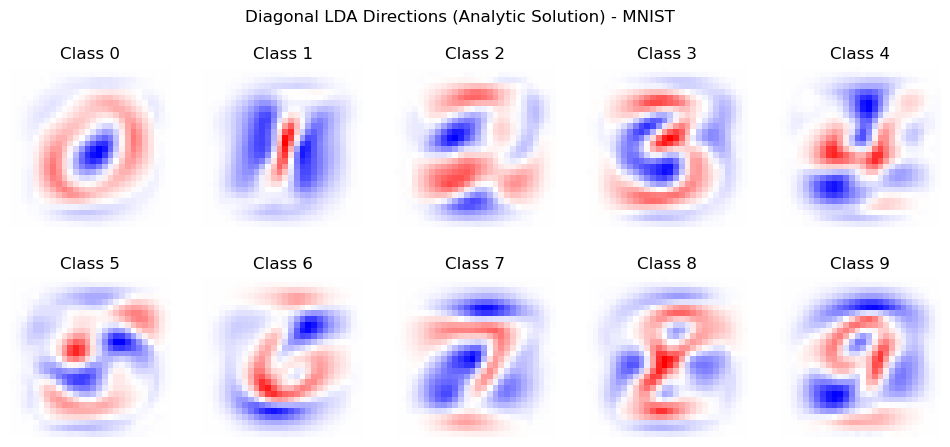

In [6]:
# Compute diagonal LDA directions (analytic solution - no training needed)
# Standardize the [0, 1] normalized data for better LDA computation, then use directions

# Load MNIST in the same format as training ([0, 1] normalized)
mnist_train = MNIST(train=True, device="cpu")  # Load on CPU first for numpy conversion
X_mnist = mnist_train.x.numpy().reshape(
    len(mnist_train), -1
)  # (N, 784) in [0, 1] range
y_mnist = mnist_train.y.numpy().astype(int)

# Standardize for LDA computation (LDA works better on standardized data)
X_mnist_std = StandardScaler().fit_transform(X_mnist)

# Compute diagonal LDA directions from standardized data
diag_lda_directions = []
for c in range(10):
    v_c = compute_diagonal_lda_direction(X_mnist_std, y_mnist, c)
    diag_lda_directions.append(v_c)
diag_lda_directions = np.array(diag_lda_directions)
print("Diagonal LDA directions shape:", diag_lda_directions.shape)

# Plot examples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for c, ax in enumerate(axes.flat):
    ax.imshow(
        diag_lda_directions[c].reshape(28, 28),
        cmap="bwr",
        vmin=-np.max(np.abs(diag_lda_directions[c])),
        vmax=np.max(np.abs(diag_lda_directions[c])),
    )
    ax.set_title(f"Class {c}")
    ax.axis("off")
plt.suptitle("Diagonal LDA Directions (Analytic Solution) - MNIST")
plt.show()


In [7]:
# %%
# Initialize neural network model using diagonal LDA directions (analytic solution)
# The diagonal LDA directions are used as initialization - the model can then be trained

device = "cuda" if torch.cuda.is_available() else "cpu"
model_diag = Model.from_config(
    d_input=784, d_hidden=256, d_output=10, n_layer=1, epochs=20
).to(device)

# Orthonormale embed via PCA (784 -> 256) in dezelfde gestandaardiseerde ruimte als LDA
pca = PCA(n_components=256, svd_solver="randomized", whiten=False)
pca.fit(X_mnist_std)  # X_mnist_std uit je LDA-cel
W_e_np = pca.components_.astype(np.float32)  # [256, 784]

with torch.no_grad():
    # Zet embed naar PCA-basis
    model_diag.embed.weight.data = torch.tensor(W_e_np, device=device)

    bilinear_layer = model_diag.blocks[0]
    bilinear_layer.weight.data.zero_()

    for c in range(10):
        v_c = torch.tensor(
            diag_lda_directions[c], dtype=torch.float32, device=device
        )  # [784]
        v_hidden = model_diag.embed.weight.data @ v_c  # [256]
        v_hidden = v_hidden / (torch.norm(v_hidden) + 1e-12)
        bilinear_layer.weight.data[c] = v_hidden
        bilinear_layer.weight.data[256 + c] = v_hidden

    for a in range(10, 256):
        bilinear_layer.weight.data[a] = torch.randn(256, device=device) * 0.01
        bilinear_layer.weight.data[256 + a] = torch.randn(256, device=device) * 0.01

    # Head als identiteitsmapping voor klassen
    model_diag.head.weight.data.zero_()
    for c in range(10):
        model_diag.head.weight.data[c, c] = 1.0

# Test initialization accuracy (before training)
# Use the same validation set that will be used during training

train, test = MNIST(train=True, device=device), MNIST(train=False, device=device)
test_indices = torch.randperm(len(test), generator=torch.Generator().manual_seed(42))


class SubsetDataset:
    def __init__(self, dataset, indices):
        self.x = torch.stack([dataset[i][0] for i in indices])
        self.y = torch.stack([dataset[i][1] for i in indices])

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)


# Standardize data to match LDA computation format (same as Cell 7)
mnist_train_full = MNIST(train=True, device="cpu")
X_train_full = mnist_train_full.x.numpy().reshape(len(mnist_train_full), -1)
scaler = StandardScaler().fit(X_train_full)


class StandardizedSubsetDataset:
    def __init__(self, dataset, indices, scaler):
        x_raw = torch.stack([dataset[i][0] for i in indices])
        self.y = torch.stack([dataset[i][1] for i in indices])
        # Standardize the data
        x_np = x_raw.cpu().numpy().reshape(len(x_raw), -1)
        x_std = scaler.transform(x_np)
        self.x = torch.tensor(x_std, dtype=torch.float32, device=x_raw.device)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)


test_ds = StandardizedSubsetDataset(test, test_indices, scaler)

model_diag.eval()
with torch.no_grad():
    logits = model_diag(test_ds.x)
    predictions = logits.argmax(dim=-1)
    accuracy_diag = (predictions == test_ds.y).float().mean().item()

print(
    f"Model initialized with Diagonal LDA directions - Validation Accuracy: {accuracy_diag * 100:.2f}%"
)

Model initialized with Diagonal LDA directions - Validation Accuracy: 75.16%


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_pca = Model.from_config(
    d_input=784, d_hidden=256, d_output=10, n_layer=1, epochs=20
).to(device)

# Fit PCA on the standardized MNIST (X_mnist_std from earlier cell)
pca = PCA(n_components=256, svd_solver="randomized", whiten=False)
pca.fit(X_mnist_std)
W_e_np = pca.components_.astype(np.float32)  # [256, 784]

with torch.no_grad():
    # Embedding = PCA basis
    model_pca.embed.weight.data = torch.tensor(W_e_np, device=device)

    bilinear_layer = model_pca.blocks[0]
    bilinear_layer.weight.data.zero_()

    # Seed per class with the first d_output PCA axes in hidden space (unit vectors)
    eye_hidden = torch.eye(256, device=device)
    for c in range(model_pca.head.weight.shape[0]):  # 10 classes
        v_hidden = eye_hidden[c]  # aligns with PC-c
        bilinear_layer.weight.data[c] = v_hidden
        bilinear_layer.weight.data[256 + c] = v_hidden  # mirror slot for symmetry

    # Fill remaining slots with small randoms
    for a in range(model_pca.head.weight.shape[0], 256):
        bilinear_layer.weight.data[a] = torch.randn(256, device=device) * 0.01
        bilinear_layer.weight.data[256 + a] = torch.randn(256, device=device) * 0.01

    # Head as identity over classes
    model_pca.head.weight.data.zero_()
    for c in range(model_pca.head.weight.shape[0]):
        model_pca.head.weight.data[c, c] = 1.0

# Evaluate initialization on the standardized subset
mnist_train_full = MNIST(train=True, device="cpu")
X_train_full = mnist_train_full.x.numpy().reshape(len(mnist_train_full), -1)
scaler = StandardScaler().fit(X_train_full)


class StandardizedSubsetDataset:
    def __init__(self, dataset, indices, scaler):
        x_raw = torch.stack([dataset[i][0] for i in indices])
        self.y = torch.stack([dataset[i][1] for i in indices])
        x_np = x_raw.cpu().numpy().reshape(len(x_raw), -1)
        x_std = scaler.transform(x_np)
        self.x = torch.tensor(x_std, dtype=torch.float32, device=x_raw.device)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)


train, test = MNIST(train=True, device=device), MNIST(train=False, device=device)
test_indices = torch.randperm(len(test), generator=torch.Generator().manual_seed(42))[
    :2000
]
test_ds = StandardizedSubsetDataset(test, test_indices, scaler)

model_pca.eval()
with torch.no_grad():
    logits = model_pca(test_ds.x)
    preds = logits.argmax(dim=-1)
    acc_init = (preds == test_ds.y).float().mean().item()

print(f"PCA-only initialization - Validation Accuracy: {acc_init * 100:.2f}%")

PCA-only initialization - Validation Accuracy: 18.10%


torch.Size([60000, 784]) torch.Size([60000])
Computing initial validation accuracy...
Initial validation accuracy: 75.16%
Initial validation loss: 7.387

Training diagonal LDA model...


train/loss: 0.048, train/acc: 0.986, val/loss: 0.148, val/acc: 0.973: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


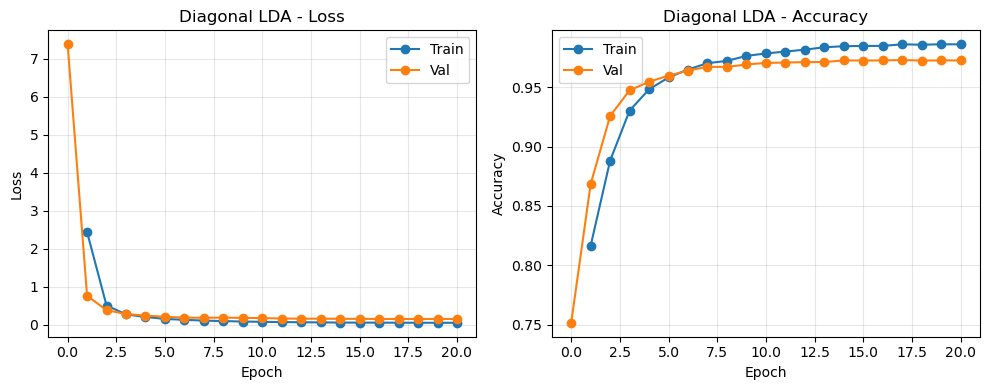

In [9]:
# %%
# Train diagonal LDA model and plot loss curves


class RandomGaussianNoise:
    def __init__(self, std=0.1):
        self.std = std

    def __call__(self, x):
        if not torch.is_tensor(x):
            x = torch.tensor(x)
        noise = torch.randn_like(x) * self.std
        return x + noise


train, test = MNIST(train=True, device=device), MNIST(train=False, device=device)
train_indices = torch.randperm(
    len(train), generator=torch.Generator().manual_seed(42)
)  # [:10000]
test_indices = torch.randperm(
    len(test), generator=torch.Generator().manual_seed(42)
)  # [:2000]

# Standardize data to match LDA computation format
mnist_train_full = MNIST(train=True, device="cpu")
X_train_full = mnist_train_full.x.numpy().reshape(len(mnist_train_full), -1)
scaler = StandardScaler().fit(X_train_full)


class StandardizedSubsetDataset:
    def __init__(self, dataset, indices, scaler, noise=None):
        x_raw = torch.stack([dataset[i][0] for i in indices])
        self.y = torch.stack([dataset[i][1] for i in indices])
        x_np = x_raw.cpu().numpy().reshape(len(x_raw), -1)
        x_std = scaler.transform(x_np)
        self.x = torch.tensor(x_std, dtype=torch.float32, device=x_raw.device)
        self.noise = noise

    def __getitem__(self, idx):
        x = self.x[idx]
        if self.noise is not None:
            x = self.noise(x)
        return x, self.y[idx]

    def __len__(self):
        return len(self.x)


train_ds = StandardizedSubsetDataset(
    train, train_indices, scaler, noise=RandomGaussianNoise(std=0.4)
)
test_ds = StandardizedSubsetDataset(test, test_indices, scaler, noise=None)

print(train_ds.x.shape, train_ds.y.shape)

# Compute initial validation accuracy (before training)
model_diag_init = copy.deepcopy(model_diag)
print("Computing initial validation accuracy...")
model_diag.eval()

with torch.no_grad():
    val_logits = model_diag(test_ds.x)
    val_preds = val_logits.argmax(dim=-1)
    initial_val_acc = (val_preds == test_ds.y).float().mean().item()
    initial_val_loss = model_diag.criterion(val_logits, test_ds.y).item()

print(f"Initial validation accuracy: {initial_val_acc * 100:.2f}%")
print(f"Initial validation loss: {initial_val_loss:.3f}")

print("\nTraining diagonal LDA model...")
metrics_diag = model_diag.fit(train_ds, test_ds)

# Prepend initial metrics to the dataframe

initial_metrics = pd.DataFrame(
    [
        {
            "train/loss": float("nan"),
            "train/acc": float("nan"),
            "val/loss": initial_val_loss,
            "val/acc": initial_val_acc,
        }
    ]
)
metrics_diag = pd.concat([initial_metrics, metrics_diag], ignore_index=True)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(metrics_diag["train/loss"], label="Train", marker="o")
plt.plot(metrics_diag["val/loss"], label="Val", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Diagonal LDA - Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(metrics_diag["train/acc"], label="Train", marker="o")
plt.plot(metrics_diag["val/acc"], label="Val", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Diagonal LDA - Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

PCA-only init - Val Acc: 17.15%, Val Loss: 47.281
Training PCA-only model...


train/loss: 0.076, train/acc: 0.978, val/loss: 0.103, val/acc: 0.973: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


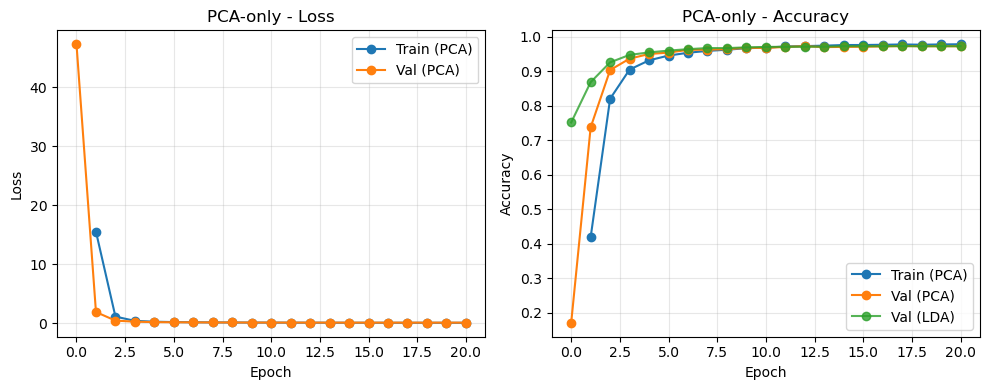

In [10]:
# Build standardized train/test for MNIST (same pipeline as LDA)
train, test = MNIST(train=True, device=device), MNIST(train=False, device=device)
mnist_train_full = MNIST(train=True, device="cpu")
X_train_full = mnist_train_full.x.numpy().reshape(len(mnist_train_full), -1)
scaler = StandardScaler().fit(X_train_full)


class RandomGaussianNoise:
    def __init__(self, std=0.1):
        self.std = std

    def __call__(self, x):
        if not torch.is_tensor(x):
            x = torch.tensor(x)
        return x + torch.randn_like(x) * self.std


class StandardizedSubsetDataset:
    def __init__(self, dataset, indices, scaler, noise=None):
        x_raw = torch.stack([dataset[i][0] for i in indices])
        self.y = torch.stack([dataset[i][1] for i in indices])
        x_np = x_raw.cpu().numpy().reshape(len(x_raw), -1)
        x_std = scaler.transform(x_np)
        self.x = torch.tensor(x_std, dtype=torch.float32, device=x_raw.device)
        self.noise = noise

    def __getitem__(self, idx):
        x = self.x[idx]
        if self.noise is not None:
            x = self.noise(x)
        return x, self.y[idx]

    def __len__(self):
        return len(self.x)


g = torch.Generator().manual_seed(42)
train_indices = torch.randperm(len(train), generator=g)
test_indices = torch.randperm(len(test), generator=g)[:2000]

train_ds = StandardizedSubsetDataset(
    train, train_indices, scaler, noise=RandomGaussianNoise(std=0.4)
)
test_ds = StandardizedSubsetDataset(test, test_indices, scaler, noise=None)

# Initial validation (before training)
model_pca_init = copy.deepcopy(model_pca)
model_pca.eval()
with torch.no_grad():
    logits0 = model_pca(test_ds.x)
    preds0 = logits0.argmax(dim=-1)
    init_acc_pca = (preds0 == test_ds.y).float().mean().item()
    init_loss_pca = model_pca.criterion(logits0, test_ds.y).item()
print(
    f"PCA-only init - Val Acc: {init_acc_pca * 100:.2f}%, Val Loss: {init_loss_pca:.3f}"
)

# Train PCA-only model
print("Training PCA-only model...")
metrics_pca = model_pca.fit(train_ds, test_ds)

# Prepend initial metrics
initial_metrics_pca = pd.DataFrame(
    [
        {
            "train/loss": float("nan"),
            "train/acc": float("nan"),
            "val/loss": init_loss_pca,
            "val/acc": init_acc_pca,
        }
    ]
)
metrics_pca = pd.concat([initial_metrics_pca, metrics_pca], ignore_index=True)

# Plot PCA-only curves and optionally compare with LDA if available
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(metrics_pca["train/loss"], label="Train (PCA)", marker="o")
plt.plot(metrics_pca["val/loss"], label="Val (PCA)", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("PCA-only - Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(metrics_pca["train/acc"], label="Train (PCA)", marker="o")
plt.plot(metrics_pca["val/acc"], label="Val (PCA)", marker="o")
if "metrics_diag" in globals():
    plt.plot(metrics_diag["val/acc"], label="Val (LDA)", marker="o", alpha=0.8)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("PCA-only - Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
print("Training randomly initialized model for comparison...")
model_random = Model.from_config(
    d_input=784, d_hidden=256, d_output=10, n_layer=1, epochs=20
).to(device)

# Compute initial validation accuracy for random model (before training)
model_random_init = copy.deepcopy(model_random)
model_random.eval()

with torch.no_grad():
    val_logits_random = model_random(test_ds.x)
    val_preds_random = val_logits_random.argmax(dim=-1)
    initial_val_acc_random = (val_preds_random == test_ds.y).float().mean().item()
    initial_val_loss_random = model_random.criterion(
        val_logits_random, test_ds.y
    ).item()

print(f"Random model initial validation accuracy: {initial_val_acc_random * 100:.2f}%")

metrics_random = model_random.fit(train_ds, test_ds)
print(
    f"Random initialization final validation accuracy: {metrics_random['val/acc'].iloc[-1]:.3f}"
)

# Prepend initial metrics to random model dataframe

initial_metrics_random = pd.DataFrame(
    [
        {
            "train/loss": float("nan"),
            "train/acc": float("nan"),
            "val/loss": initial_val_loss_random,
            "val/acc": initial_val_acc_random,
        }
    ]
)
metrics_random = pd.concat([initial_metrics_random, metrics_random], ignore_index=True)

# Plot comparison

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=metrics_diag.index,
        y=metrics_diag["val/acc"],
        name="Diagonal LDA",
        line=dict(color="green", width=2),
        marker=dict(size=4),
    )
)
fig.add_trace(
    go.Scatter(
        x=metrics_pca.index,
        y=metrics_pca["val/acc"],
        name="PCA",
        line=dict(color="blue", width=2),
        marker=dict(size=4),
    )
)
fig.add_trace(
    go.Scatter(
        x=metrics_random.index,
        y=metrics_random["val/acc"],
        name="Random",
        line=dict(color="red", width=2),
        marker=dict(size=4),
    )
)
fig.update_layout(
    title="MNIST: Validation Accuracy Comparison",
    xaxis_title="Epoch",
    yaxis_title="Accuracy",
    template="plotly_white",
    width=800,
    height=500,
)
fig.show()

Training randomly initialized model for comparison...
Random model initial validation accuracy: 13.85%


train/loss: 0.027, train/acc: 0.992, val/loss: 0.084, val/acc: 0.979: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]

Random initialization final validation accuracy: 0.979


In [12]:
# Plot comparison

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=metrics_diag.index,
        y=metrics_diag["val/acc"],
        name="Diagonal LDA",
        line=dict(color="green", width=2),
        marker=dict(size=4),
    )
)
fig.add_trace(
    go.Scatter(
        x=metrics_pca.index,
        y=metrics_pca["val/acc"],
        name="PCA",
        line=dict(color="blue", width=2),
        marker=dict(size=4),
    )
)
fig.update_layout(
    title="MNIST: Validation Accuracy Comparison",
    xaxis_title="Epoch",
    yaxis_title="Accuracy",
    template="plotly_white",
    width=800,
    height=500,
)
fig.show()

In [13]:
digit = 5  # Change this to visualize other digits
n_eigenvectors = 3

for model, name in zip(
    [
        (model_diag, model_diag_init),
        (model_pca, model_pca_init),
        (model_random, model_random_init),
        (model_base, model_base_init),
    ],
    ["Diagonal LDA", "PCA", "Random", "Baseline"],
):
    model[1].eval()
    # print(f"Before Training - Model {name} - Digit {digit}")
    fig1 = plot_eigenspectrum(model[1], digit=digit, eigenvectors=n_eigenvectors)

    model[0].eval()
    # print(f"After Training - Model {name} - Digit {digit}")
    fig2 = plot_eigenspectrum(model[0], digit=digit, eigenvectors=n_eigenvectors)

    fig1.update_layout(
        title=dict(
            text=f"Before Training – Digit {digit} – Model {name}",
            x=0.5,
            xanchor="center",
        ),
        margin=dict(t=40),
    )
    fig1.show()

    fig2.update_layout(
        title=dict(
            text=f"After Training – Digit {digit} – Model {name}",
            x=0.5,
            xanchor="center",
        ),
        margin=dict(t=40),
    )
    fig2.show()

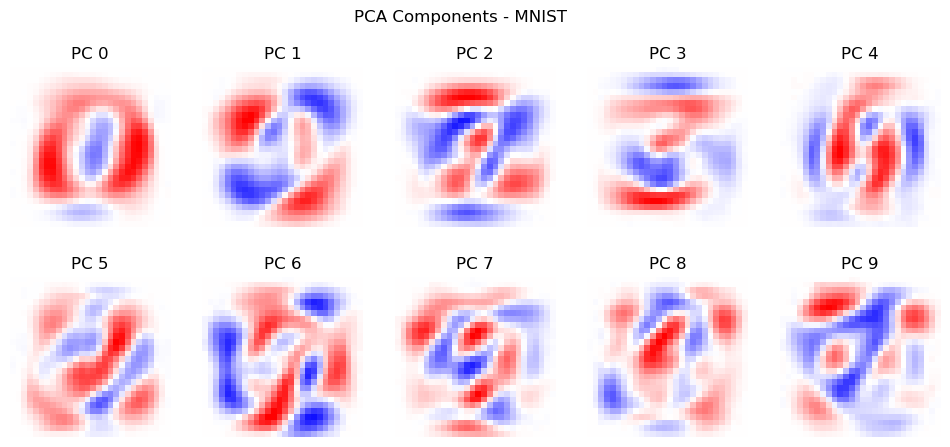

In [14]:
# visualize top eigenvector for each class before trianing for LDA and PCA models

# PCA
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for c, ax in enumerate(axes.flat):
    pc_vector = W_e_np[c]  # First 10 PCA components
    ax.imshow(
        pc_vector.reshape(28, 28),
        cmap="bwr",
        vmin=-np.max(np.abs(pc_vector)),
        vmax=np.max(np.abs(pc_vector)),
    )
    ax.set_title(f"PC {c}")
    ax.axis("off")
plt.suptitle("PCA Components - MNIST")
plt.show()

## Diagonal LDA for CIFAR-10

Loading CIFAR-10...
Files already downloaded and verified


/Users/shidqietaufiqurrahman/workspace/miniconda3/envs/fact-ai/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning:

dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)



Files already downloaded and verified
CIFAR-10 training shape: (50000, 3072)
Scaler fitted on training data (mean: [130.71074 136.05614 132.5538  130.14036 135.44238], std: [73.41213925 72.90725141 80.4489467  72.44186593 71.90059666])
Computing diagonal LDA directions...


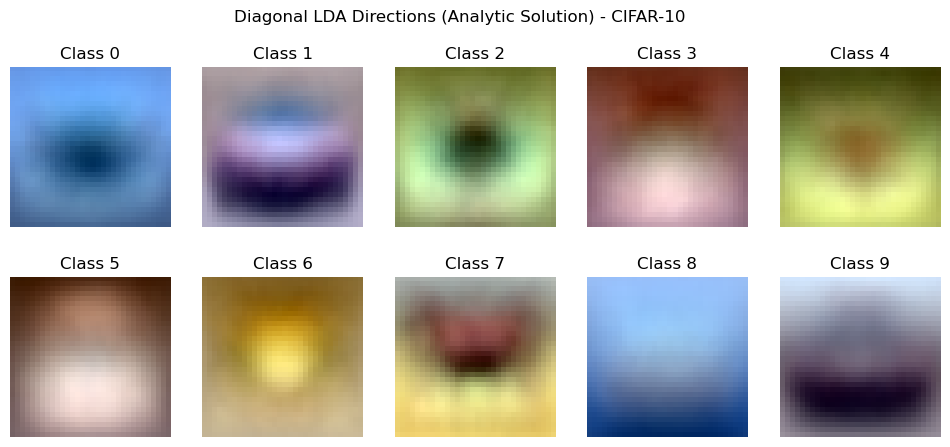

In [15]:
# %%
# Load CIFAR-10

print("Loading CIFAR-10...")
cifar_train = datasets.CIFAR10(root="./data", train=True, download=True)
cifar_test = datasets.CIFAR10(root="./data", train=False, download=True)

X_cifar_train = np.array([np.array(img) for img, _ in cifar_train])
y_cifar_train = np.array([label for _, label in cifar_train])
X_cifar_test = np.array([np.array(img) for img, _ in cifar_test])
y_cifar_test = np.array([label for _, label in cifar_test])

X_cifar_flat = X_cifar_train.reshape(len(X_cifar_train), -1).astype(np.float32)
y_cifar = y_cifar_train.astype(int)

# Standardize training data and save scaler for consistent use
scaler_cifar = StandardScaler()
X_cifar_scaled = scaler_cifar.fit_transform(X_cifar_flat)
print(f"CIFAR-10 training shape: {X_cifar_scaled.shape}")
print(
    f"Scaler fitted on training data (mean: {scaler_cifar.mean_[:5]}, std: {scaler_cifar.scale_[:5]})"
)

# Compute diagonal LDA directions (analytic solution - no training needed)
print("Computing diagonal LDA directions...")
diag_lda_cifar = []
for c in range(10):
    v_c = compute_diagonal_lda_direction(X_cifar_scaled, y_cifar, c, reg=1e-3)
    diag_lda_cifar.append(v_c)
diag_lda_cifar = np.array(diag_lda_cifar)

# Plot examples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for c, ax in enumerate(axes.flat):
    img = diag_lda_cifar[c].reshape(32, 32, 3)
    img = (img - img.min()) / (img.max() - img.min())
    ax.imshow(np.clip(img, 0, 1))
    ax.set_title(f"Class {c}")
    ax.axis("off")
plt.suptitle("Diagonal LDA Directions (Analytic Solution) - CIFAR-10")
plt.show()

Model initialized with Diagonal LDA directions - Validation Accuracy: 19.45%
(This should match the first epoch validation accuracy in training)


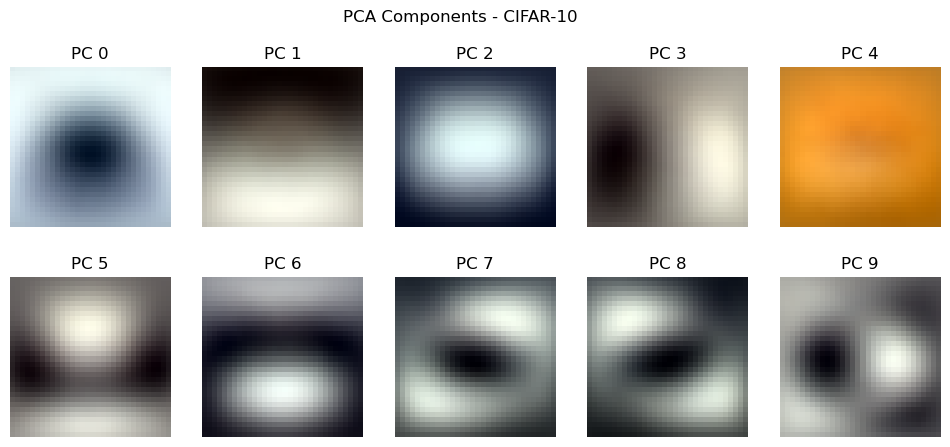

In [16]:
# %%
# Initialize neural network model using diagonal LDA directions (analytic solution)
# The diagonal LDA directions are used as initialization - the model can then be trained

device = "cuda" if torch.cuda.is_available() else "cpu"
model_cifar_diag = Model.from_config(
    d_input=3072, d_hidden=256, d_output=10, n_layer=1, epochs=20
).to(device)

X_cifar_torch = torch.tensor(X_cifar_scaled, dtype=torch.float32, device=device)
y_cifar_torch = torch.tensor(y_cifar, dtype=torch.long, device=device)

# Orthonormale embed via PCA (784 -> 256) in dezelfde gestandaardiseerde ruimte als LDA
pca = PCA(n_components=256, svd_solver="randomized", whiten=False)
pca.fit(X_cifar_torch.cpu())  # X_mnist_std uit je LDA-cel
W_e_np = pca.components_.astype(np.float32)  # [256, 784]

with torch.no_grad():
    model_cifar_diag.embed.weight.data = torch.tensor(W_e_np, device=device)

    bilinear_layer = model_cifar_diag.blocks[0]
    bilinear_layer.weight.data.zero_()

    for c in range(10):
        v_c = torch.tensor(diag_lda_cifar[c], dtype=torch.float32, device=device)
        v_hidden = model_cifar_diag.embed.weight.data @ v_c
        v_hidden = v_hidden / torch.norm(v_hidden)
        bilinear_layer.weight.data[c] = v_hidden
        bilinear_layer.weight.data[256 + c] = v_hidden

    for a in range(10, 256):
        bilinear_layer.weight.data[a] = torch.randn(256, device=device) * 0.01
        bilinear_layer.weight.data[256 + a] = torch.randn(256, device=device) * 0.01

    model_cifar_diag.head.weight.data.zero_()
    for c in range(10):
        model_cifar_diag.head.weight.data[c, c] = 1.0

# Test initialization accuracy (before training)
# Use the same validation set that will be used during training
# Standardize test data using the SAME scaler fitted on training data (from Cell 10)
X_cifar_test_flat = X_cifar_test.reshape(len(X_cifar_test), -1).astype(np.float32)
X_cifar_test_scaled = scaler_cifar.transform(
    X_cifar_test_flat
)  # Use scaler from Cell 10
X_cifar_test_torch = torch.tensor(
    X_cifar_test_scaled, dtype=torch.float32, device=device
)
y_cifar_test_torch = torch.tensor(y_cifar_test, dtype=torch.long, device=device)

# Use the same validation set as training (first 2000 samples)
X_val_init = X_cifar_test_torch[:2000]
y_val_init = y_cifar_test_torch[:2000]

model_cifar_diag.eval()
with torch.no_grad():
    logits = model_cifar_diag(X_val_init)
    predictions = logits.argmax(dim=-1)
    accuracy_cifar_diag = (predictions == y_val_init).float().mean().item()

print(
    f"Model initialized with Diagonal LDA directions - Validation Accuracy: {accuracy_cifar_diag * 100:.2f}%"
)
print(f"(This should match the first epoch validation accuracy in training)")


# PCA
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for c, ax in enumerate(axes.flat):
    pc_vector = W_e_np[c]  # [3072]
    img = pc_vector.reshape(32, 32, 3)  # [32,32,3]
    img = (img - img.min()) / (img.max() - img.min() + 1e-12)
    ax.imshow(img)
    ax.set_title(f"PC {c}")
    ax.axis("off")
plt.suptitle("PCA Components - CIFAR-10")
plt.show()

In [17]:
# %%
# PCA-only initialization for CIFAR-10 (no LDA), using a distinct model name

device = "cuda" if torch.cuda.is_available() else "cpu"
model_cifar_pca = Model.from_config(
    d_input=3072, d_hidden=256, d_output=10, n_layer=1, epochs=20
).to(device)

# Use standardized CIFAR-10 training data (X_cifar_scaled from the previous cell)
X_cifar_torch = torch.tensor(
    X_cifar_scaled, dtype=torch.float32, device="cpu"
)  # fit PCA on CPU numpy
pca = PCA(n_components=256, svd_solver="randomized", whiten=False)
pca.fit(X_cifar_torch.numpy())
W_e_np = pca.components_.astype(np.float32)  # [256, 3072]

with torch.no_grad():
    # Set embedding to PCA basis
    model_cifar_pca.embed.weight.data = torch.tensor(W_e_np, device=device)

    bilinear_layer = model_cifar_pca.blocks[0]
    bilinear_layer.weight.data.zero_()

    # Seed per class with unit axes in hidden space (first 10 PCs); no LDA used
    eye_hidden = torch.eye(256, device=device)
    for c in range(model_cifar_pca.head.weight.shape[0]):  # 10 classes
        v_hidden = eye_hidden[c]
        bilinear_layer.weight.data[c] = v_hidden
        bilinear_layer.weight.data[256 + c] = v_hidden

    # Fill remaining slots with small randoms
    for a in range(model_cifar_pca.head.weight.shape[0], 256):
        bilinear_layer.weight.data[a] = torch.randn(256, device=device) * 0.01
        bilinear_layer.weight.data[256 + a] = torch.randn(256, device=device) * 0.01

    # Head as identity over classes
    model_cifar_pca.head.weight.data.zero_()
    for c in range(model_cifar_pca.head.weight.shape[0]):
        model_cifar_pca.head.weight.data[c, c] = 1.0

# Test initialization accuracy (before training) using the SAME scaler from training
X_cifar_test_flat = X_cifar_test.reshape(len(X_cifar_test), -1).astype(np.float32)
X_cifar_test_scaled = scaler_cifar.transform(X_cifar_test_flat)
X_cifar_test_torch = torch.tensor(
    X_cifar_test_scaled, dtype=torch.float32, device=device
)
y_cifar_test_torch = torch.tensor(y_cifar_test, dtype=torch.long, device=device)

# Use first 2000 samples for validation
X_val_init = X_cifar_test_torch[:2000]
y_val_init = y_cifar_test_torch[:2000]

model_cifar_pca.eval()
with torch.no_grad():
    logits = model_cifar_pca(X_val_init)
    predictions = logits.argmax(dim=-1)
    accuracy_cifar_pca = (predictions == y_val_init).float().mean().item()

print(f"PCA-only initialization - Validation Accuracy: {accuracy_cifar_pca * 100:.2f}%")


PCA-only initialization - Validation Accuracy: 11.05%


Computing initial validation accuracy...
Initial validation accuracy: 19.45%
Initial validation loss: 450.445

Training CIFAR-10 diagonal LDA model...


train/loss: 2.192, train/acc: 0.321, val/loss: 2.283, val/acc: 0.287: 100%|██████████| 20/20 [00:01<00:00, 14.64it/s]   


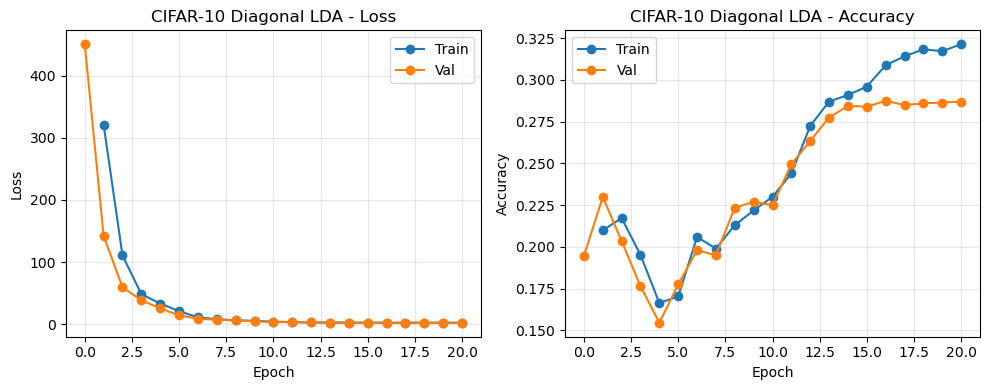

In [18]:
# %%
# Train CIFAR-10 diagonal LDA model and plot loss curves

# Create datasets for training
class CIFAR10Dataset:
    def __init__(self, X, y):
        self.x = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.long).to(device)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)


train_cifar_ds = CIFAR10Dataset(X_cifar_scaled[:10000], y_cifar[:10000])
test_cifar_ds = CIFAR10Dataset(X_cifar_test_scaled[:2000], y_cifar_test[:2000])

# Compute initial validation accuracy (before training)
print("Computing initial validation accuracy...")
model_cifar_diag.eval()
with torch.no_grad():
    val_logits = model_cifar_diag(test_cifar_ds.x)
    val_preds = val_logits.argmax(dim=-1)
    initial_val_acc = (val_preds == test_cifar_ds.y).float().mean().item()
    initial_val_loss = model_cifar_diag.criterion(val_logits, test_cifar_ds.y).item()

print(f"Initial validation accuracy: {initial_val_acc * 100:.2f}%")
print(f"Initial validation loss: {initial_val_loss:.3f}")

print("\nTraining CIFAR-10 diagonal LDA model...")
metrics_cifar_diag = model_cifar_diag.fit(train_cifar_ds, test_cifar_ds)

# Prepend initial metrics to the dataframe

initial_metrics = pd.DataFrame(
    [
        {
            "train/loss": float("nan"),
            "train/acc": float("nan"),
            "val/loss": initial_val_loss,
            "val/acc": initial_val_acc,
        }
    ]
)
metrics_cifar_diag = pd.concat([initial_metrics, metrics_cifar_diag], ignore_index=True)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(metrics_cifar_diag["train/loss"], label="Train", marker="o")
plt.plot(metrics_cifar_diag["val/loss"], label="Val", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CIFAR-10 Diagonal LDA - Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(metrics_cifar_diag["train/acc"], label="Train", marker="o")
plt.plot(metrics_cifar_diag["val/acc"], label="Val", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CIFAR-10 Diagonal LDA - Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Computing initial validation accuracy (PCA-only)...
Initial validation accuracy: 11.05%
Initial validation loss: 885.396

Training CIFAR-10 PCA-only model...


train/loss: 2.889, train/acc: 0.208, val/loss: 3.039, val/acc: 0.188: 100%|██████████| 20/20 [00:01<00:00, 14.20it/s]   


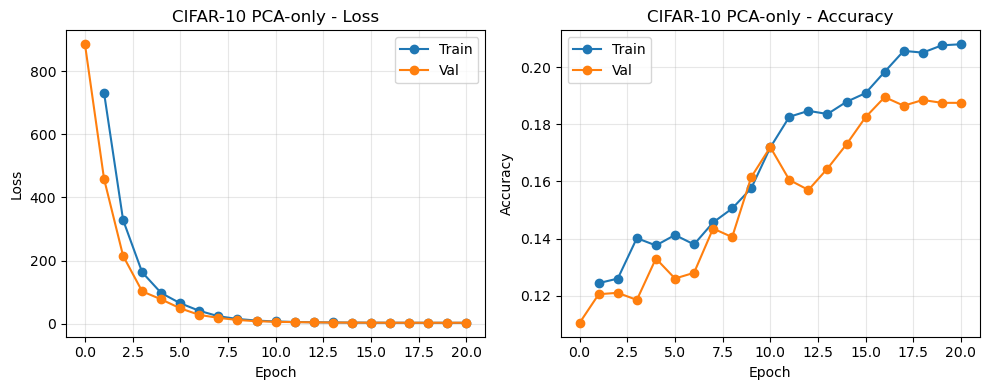

In [19]:
# %%
# Train CIFAR-10 PCA-only model and plot loss curves

# Create datasets for training
class CIFAR10Dataset:
    def __init__(self, X, y):
        self.x = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.long).to(device)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)


train_cifar_ds = CIFAR10Dataset(X_cifar_scaled[:10000], y_cifar[:10000])
test_cifar_ds = CIFAR10Dataset(X_cifar_test_scaled[:2000], y_cifar_test[:2000])

# Compute initial validation accuracy (before training)
print("Computing initial validation accuracy (PCA-only)...")
model_cifar_pca.eval()
with torch.no_grad():
    val_logits = model_cifar_pca(test_cifar_ds.x)
    val_preds = val_logits.argmax(dim=-1)
    initial_val_acc = (val_preds == test_cifar_ds.y).float().mean().item()
    initial_val_loss = model_cifar_pca.criterion(val_logits, test_cifar_ds.y).item()

print(f"Initial validation accuracy: {initial_val_acc * 100:.2f}%")
print(f"Initial validation loss: {initial_val_loss:.3f}")

print("\nTraining CIFAR-10 PCA-only model...")
metrics_cifar_pca = model_cifar_pca.fit(train_cifar_ds, test_cifar_ds)

# Prepend initial metrics to the dataframe

initial_metrics = pd.DataFrame(
    [
        {
            "train/loss": float("nan"),
            "train/acc": float("nan"),
            "val/loss": initial_val_loss,
            "val/acc": initial_val_acc,
        }
    ]
)
metrics_cifar_pca = pd.concat([initial_metrics, metrics_cifar_pca], ignore_index=True)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(metrics_cifar_pca["train/loss"], label="Train", marker="o")
plt.plot(metrics_cifar_pca["val/loss"], label="Val", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CIFAR-10 PCA-only - Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(metrics_cifar_pca["train/acc"], label="Train", marker="o")
plt.plot(metrics_cifar_pca["val/acc"], label="Val", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CIFAR-10 PCA-only - Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
print("Training randomly initialized CIFAR-10 model for comparison...")
model_cifar_random = Model.from_config(
    d_input=3072, d_hidden=256, d_output=10, n_layer=1, epochs=20
).to(device)

# Compute initial validation accuracy for random model (before training)
model_cifar_random.eval()
with torch.no_grad():
    val_logits_random = model_cifar_random(test_cifar_ds.x)
    val_preds_random = val_logits_random.argmax(dim=-1)
    initial_val_acc_random = (val_preds_random == test_cifar_ds.y).float().mean().item()
    initial_val_loss_random = model_cifar_random.criterion(
        val_logits_random, test_cifar_ds.y
    ).item()

print(f"Random model initial validation accuracy: {initial_val_acc_random * 100:.2f}%")

metrics_cifar_random = model_cifar_random.fit(train_cifar_ds, test_cifar_ds)
print(
    f"Random initialization final validation accuracy: {metrics_cifar_random['val/acc'].iloc[-1]:.3f}"
)

# Prepend initial metrics to random model dataframe

initial_metrics_random = pd.DataFrame(
    [
        {
            "train/loss": float("nan"),
            "train/acc": float("nan"),
            "val/loss": initial_val_loss_random,
            "val/acc": initial_val_acc_random,
        }
    ]
)
metrics_cifar_random = pd.concat(
    [initial_metrics_random, metrics_cifar_random], ignore_index=True
)

# Plot comparison


fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=metrics_cifar_diag.index,
        y=metrics_cifar_diag["val/acc"],
        name="Diagonal LDA",
        line=dict(color="green", width=2),
        marker=dict(size=4),
    )
)
fig.add_trace(
    go.Scatter(
        x=metrics_cifar_pca.index,
        y=metrics_cifar_pca["val/acc"],
        name="PCA",
        line=dict(color="blue", width=2),
        marker=dict(size=4),
    )
)
fig.add_trace(
    go.Scatter(
        x=metrics_cifar_random.index,
        y=metrics_cifar_random["val/acc"],
        name="Random",
        line=dict(color="red", width=2),
        marker=dict(size=4),
    )
)
fig.update_layout(
    title="CIFAR-10: Validation Accuracy Comparison",
    xaxis_title="Epoch",
    yaxis_title="Accuracy",
    template="plotly_white",
    width=800,
    height=500,
)
fig.show()

Training randomly initialized CIFAR-10 model for comparison...
Random model initial validation accuracy: 9.30%


train/loss: 1.658, train/acc: 0.447, val/loss: 1.834, val/acc: 0.372: 100%|██████████| 20/20 [00:01<00:00, 13.60it/s]

Random initialization final validation accuracy: 0.372
